# Examples on Barrier Constraint

In this notebook, we will consider the constraint defined by

$$ \forall t\in [0,1], \int_{\Omega} H(t,x) d\rho_t(x) = 0 \tag*{}$$

where $H(t,x)$ is positive on the region where we want to disallow mass and zero elsewhere. This is called the **barrier constraint**. For details on experiments, please refer to the code as well as our paper.

# Static Barrier Constraint

We will consider the maze as defined by `input/maze.png` and put the initial density on top left and the terminal density on bottom right. 

In [1]:
# Import necessary libraries & define functions
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from proximal.dynamicUOT import computeGeodesic
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact
from PIL import Image

def image_to_numpy(image_path):
    # Load the image file
    image = Image.open(image_path).convert('L')  # Convert image to grayscale if it's not

    # Convert the PIL image to a numpy array
    image_array = np.array(image)

    return image_array

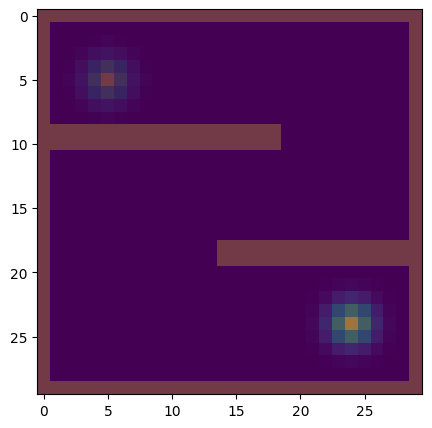

In [ ]:
# Calculation of the geodesics
maze = (1-image_to_numpy('input/maze.png').squeeze()/255)

T = 30
N1 = maze.shape[0]
N2 = maze.shape[1]

H = [[np.repeat(maze[np.newaxis, :, :], T, axis=0), np.zeros((T, N1, N2)), np.zeros((T, N1, N2)), np.zeros((T, N1, N2))]]
GL = [np.zeros(T)]
GU = [np.zeros(T)]

dx = [1./N1, 1./N2]

indices = np.arange(0, 30) * 1./30
xx, yy = np.meshgrid(indices, indices)

rho_0_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[5./30., 5./30.], cov=2./36**2)
rho_1_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[24./30., 24./30.], cov=2./36**2)

plt.figure(figsize=(5, 5))
plt.imshow(maze)
plt.imshow(rho_0_1, alpha=0.5)
plt.imshow(rho_1_1, alpha=0.5)
plt.show()
ll=(1.0, 1.0, 1.0)
x_1, lists = computeGeodesic(rho_0_1, rho_1_1, T, ll, H=H, GL=GL, GU=GU,delta=10.0, niter=7000)

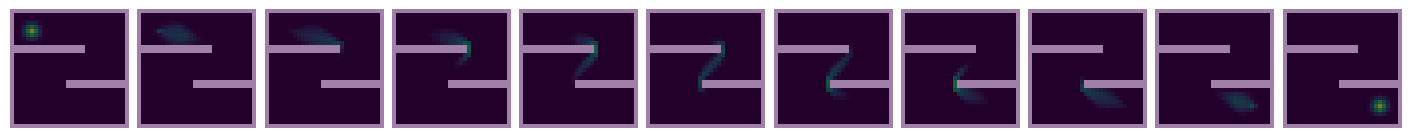

In [6]:
# Plotting the geodesic

# -------------------------------------------------
# 1.  Choose the times (as fractions of total T)
# -------------------------------------------------
snap_fracs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
snap_idx   = [int(round(f * T)) for f in snap_fracs]

# -------------------------------------------------
# 2.  Gather the density grids
# -------------------------------------------------
densities = []
for k in snap_idx:
    if k == 0:
        densities.append(rho_0_1)
    elif k == T:
        densities.append(rho_1_1)
    else:
        densities.append(x_1.V.D[0][k])        # density field at step k

# Common color scale for all panels
vmin = min(d.min() for d in densities)
vmax = max(d.max() for d in densities)

# -------------------------------------------------
# 3.  Plot: maze first (as obstacle), then density
# -------------------------------------------------
fig, axes = plt.subplots(1, len(densities), figsize=(14, 3), constrained_layout=True)

for ax, dens in zip(axes, densities):
    ax.imshow(dens, cmap='viridis', vmin=vmin, vmax=vmax, origin='upper')
    ax.imshow(maze, cmap='Greys_r', alpha=0.5, origin='upper')    # obstacle
    ax.axis('off')                                                # no ticks/labels

# Optional: save
fig.savefig("figures/006-static-barrier.png", dpi=300, bbox_inches='tight')

plt.show()

# Moving Barrier Constraint

In [9]:
# Import necessary libraries & define functions
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from proximal.dynamicUOT import computeGeodesic
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact
from PIL import Image

def image_to_numpy(image_path):
    # Load the image file
    image = Image.open(image_path).convert('L')  # Convert image to grayscale if it's not

    # Convert the PIL image to a numpy array
    image_array = np.array(image)

    return image_array

def fill_region(frames, fps, speed, original, Hstep):
    rows, cols = 30, 30
    step_size = speed*14/fps

    # Define the region to fill
    start_col, end_col = 1, 14

    # Create a list to store each frame
    filled_frames = [original]

    for i in range(1,frames):
        frame = filled_frames[-1].copy()
        # Determine the slice to fill based on speed
        end_fill = max(1, int(end_col - i*step_size))
        frame[18:20, end_fill:14] += Hstep
        # if above 1, clip to 1
        frame[frame > 1] = 1
        
        # Append the current state of the array to the list
        filled_frames.append(frame.copy())
    
    return filled_frames

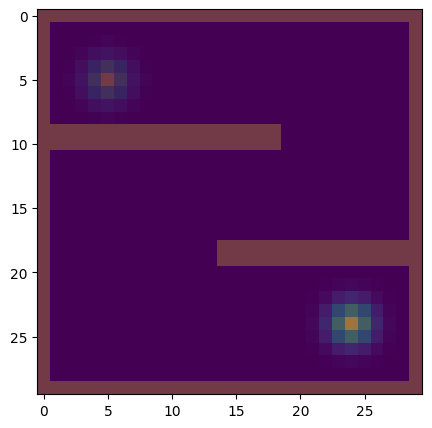

Solution saved to results\moving-barrier.npz


In [10]:
# Calculation of the geodesic
T = 30
N1 = maze.shape[0]
N2 = maze.shape[1]

dx = [1./N1, 1./N2]

indices = np.arange(0, 30) * 1./30
xx, yy = np.meshgrid(indices, indices)

rho_0_2 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[5./30., 5./30.], cov=2./36**2)
rho_1_2 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[24./30., 24./30.], cov=2./36**2)

plt.figure(figsize=(5, 5))
plt.imshow(maze)
plt.imshow(rho_0_2, alpha=0.5)
plt.imshow(rho_1_2, alpha=0.5)
plt.show()

# Generate frames
frames = fill_region(T, 30, 1.0, maze, Hstep=1.0)
barrier = np.stack(frames, axis=0)
H = [[barrier, np.zeros((T, N1, N2)), np.zeros((T, N1, N2)), np.zeros((T, N1, N2))]]
GL = [np.zeros(T)]
GU = [np.zeros(T)]

ll=(1.0, 1.0, 1.0)
x_2, lists = computeGeodesic(rho_0_2, rho_1_2, T, ll, H=H, GL=GL, GU=GU, delta=10.0, niter=7000)

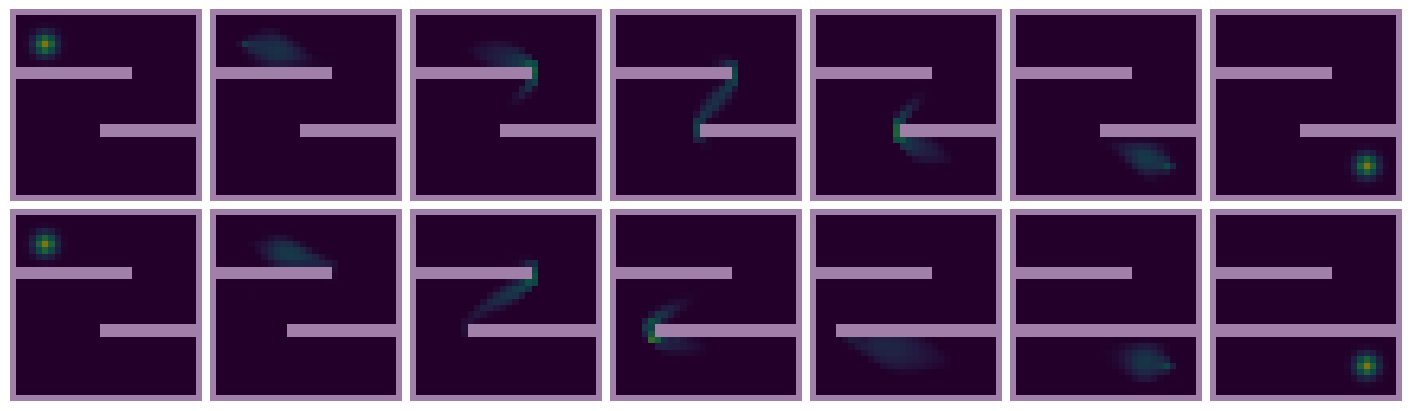

In [14]:
# Plotting the geodesic
# -------------------------------------------------
# 1.  Pick the five time-steps in *each* run
# -------------------------------------------------
T1, T2 = 30, 30
snap_fracs = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]                # 0 … 1
idx1 = [int(round(f * T1)) for f in snap_fracs]           # run #1
idx2 = [int(round(f * T2)) for f in snap_fracs]           # run #2

# -------------------------------------------------
# 2.  Collect densities and obstacle masks
#     (adapt names if yours differ)
# -------------------------------------------------
densities1 = [rho_0_1] + [x_1.V.D[0][k] for k in idx1[1:-1]] + [rho_1_1]
densities2 = [rho_0_2] + [x_2.V.D[0][k] for k in idx2[1:-1]] + [rho_1_2]

obstacles1 = [maze] * len(snap_fracs)                     # static
H_add = np.concat([barrier, barrier[-1].reshape(1, 30, 30)], 0)
obstacles2 = [(H_add[k] > 0) for k in idx2]       # dynamic

# -------------------------------------------------
# 3.  One common colour scale (optional but nicer)
# -------------------------------------------------
vmin = min(d.min() for d in densities1 + densities2)
vmax = max(d.max() for d in densities1 + densities2)

# -------------------------------------------------
# 4.  Build the 2 × 5 panel
# -------------------------------------------------
fig, axes = plt.subplots(2, len(snap_fracs), figsize=(14, 4), constrained_layout=True)

for r, (dens_set, obs_set) in enumerate([(densities1, obstacles1),
                                         (densities2, obstacles2)]):
    for c, (dens, obs) in enumerate(zip(dens_set, obs_set)):
        ax = axes[r, c]
        ax.imshow(dens, cmap='viridis', vmin=vmin, vmax=vmax,
                  origin='upper')
        ax.imshow(obs, cmap='Greys_r', alpha=0.5, origin='upper')   # obstacle
        ax.axis('off')

# Optional: save to file
fig.savefig("figures/007-static-vs-dynamic.png", dpi=300, bbox_inches='tight')

plt.show()